## nInputs analysis
Analyze output from the nInputs experiment.

In [30]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, "../utils/")
import HH, WB, Stimuli

from sklearn.neighbors import KernelDensity

# used for spike train comparison
from quantities import ms, s, Hz
import elephant.statistics as estats
import elephant
import neo
from elephant.spike_train_dissimilarity import victor_purpura_distance
from elephant.spike_train_dissimilarity import van_rossum_distance

## load data

In [2]:
def read_events_from_file(fname):
    with open(fname, 'r') as f:
        events = f.readlines()
        events = [float(event.strip()) for event in events]
        return events
    
def remove_duplicate_spikes(events):
    events = list(set(events))
    events.sort()
    return events

output_dir = '../data/nInputs/'
output_dir_nos = '../data/nInputs_no_ospike/'
output_dir_wb = '../data/nInputs_WB/'
figures_dir='../figures/'

In [3]:
nInputs_results = {
    'base':{},
    'lw':{},
    'lt':{},
    'lwlt':{},
    'burst':{},
}

nInputs_nos_results = {
    'base':{},
    'lw':{},
    'lt':{},
    'lwlt':{},
    'burst':{},
}

nInputs_stimuli = {
    'base':{'e':{},'i':{}},
    'lw':{'e':{},'i':{}},
    'lt':{'e':{},'i':{}},
    'lwlt':{'e':{},'i':{}},
    'burst':{'e':{},'i':{}},
}

nInputs_nos_stimuli = {
    'base':{'e':{},'i':{}},
    'lw':{'e':{},'i':{}},
    'lt':{'e':{},'i':{}},
    'lwlt':{'e':{},'i':{}},
    'burst':{'e':{},'i':{}},
}

In [4]:
# Wang Buzsaki model
nInputs_wb_results = {
    'wb':{}
}
nInputs_wb_stimuli = {
    'wb':{'e':{},'i':{}},
}

In [5]:
for file in os.listdir(output_dir):
    if 'istims' not in file and 'estims' not in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_results[model_type][n] = remove_duplicate_spikes(read_events_from_file(output_dir+file))
    elif 'istims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type]['i'][n] = read_events_from_file(output_dir+file)
    elif 'estims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_stimuli[model_type]['e'][n] = read_events_from_file(output_dir+file)
        
for file in os.listdir(output_dir_nos):
    if 'istims' not in file and 'estims' not in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_nos_results[model_type][n] = remove_duplicate_spikes(read_events_from_file(output_dir_nos+file))
    elif 'istims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_nos_stimuli[model_type]['i'][n] = read_events_from_file(output_dir_nos+file)
    elif 'estims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_nos_stimuli[model_type]['e'][n] = read_events_from_file(output_dir_nos+file)

In [6]:
for file in os.listdir(output_dir_wb):
    if 'istims' not in file and 'estims' not in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_wb_results[model_type][n] = remove_duplicate_spikes(read_events_from_file(output_dir_wb+file))
    elif 'istims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_wb_stimuli[model_type]['i'][n] = read_events_from_file(output_dir_wb+file)
    elif 'estims' in file:
        model_type = file.split('_')[0]
        n = int(file.split('_')[1])
        nInputs_wb_stimuli[model_type]['e'][n] = read_events_from_file(output_dir_wb+file)

## compare to normal HH simulation

In [7]:
nInputs_events = {
    'base':None,
    'lw':None,
    'lt':None,
    'lwlt':None,
    'burst':None,
}

for model_type in nInputs_stimuli:
    estims = nInputs_stimuli[model_type]['e'][30]
    istims = nInputs_stimuli[model_type]['i'][30]
    events = [('e',estim) for estim in estims] + [('i', istim) for istim in istims]
    events.sort(key = lambda x: x[1])
    nInputs_events[model_type] = events

In [8]:
nInputs_wb_events = {
    'wb':None,
}

for model_type in nInputs_wb_stimuli:
    estims = nInputs_wb_stimuli[model_type]['e'][30]
    istims = nInputs_wb_stimuli[model_type]['i'][30]
    events = [('e',estim) for estim in estims] + [('i', istim) for istim in istims]
    events.sort(key = lambda x: x[1])
    nInputs_wb_events[model_type] = events

In [9]:
gTruth_results = {
    'base':None,
    'lw':None,
    'lt':None,
    'lwlt':None,
    'burst':None,
}

duration = 100000

stim_params = Stimuli.ExperimentalStimParams()

median_histories = {
    'base':
        {
            'v': -65.4783123433392,
            'm': 0.05010827491974185,
            'n': 0.3322977316054023,
            'h': 0.5662937503578902
        },
    'lw':
        {
            'v': -65.05216588491975,
            'm': 0.053287759884193084,
            'n': 0.33057516280125593,
            'h': 0.5677966607940762
        },
    'lt':
        {
            'v': -65.33224022733997,
            'm': 0.05173948745008535,
            'n': 0.3382151028430245,
            'h': 0.5478173816286583},
    'burst':
        {
            'v': -60.34919267323213,
            'm': 0.0930119959051144,
            'n': 0.4159070018061663,
            'h': 0.3913119513056261
         },
    'lwlt':
        {
            'v': -64.26695731748968,
            'm': 0.058854810796640095,
            'n': 0.35634157654504517,
            'h': 0.511360555565485
        },
    'wb':
        {
            'v': -62.63896424137329, 
            'm': 0.10259466539537955, 
            'h': 0.7298860063700434
        }
 }

for model_type in gTruth_results:
    print(model_type)
    history = median_histories[model_type]
    events = nInputs_events[model_type]
    params = stim_params.stim_scaffold[model_type]
    
    gTruth_results[model_type] = HH.run_event_sim(
        events, 
        history, 
        params['ex'].weight, 
        params['ex'].tau, 
        params['ex'].rev_potential, 
        params['in'].weight, 
        params['in'].tau, 
        params['in'].rev_potential, 
        duration
    )

base
lw
lt
lwlt
burst


In [10]:
stim_params.stim_scaffold

{'base': {'ex': <Stimuli.PoissonStim at 0x7f8440634910>,
  'in': <Stimuli.PoissonStim at 0x7f8440635900>},
 'lw': {'ex': <Stimuli.PoissonStim at 0x7f84406349a0>,
  'in': <Stimuli.PoissonStim at 0x7f8440635e40>},
 'lt': {'ex': <Stimuli.PoissonStim at 0x7f84406344c0>,
  'in': <Stimuli.PoissonStim at 0x7f8440636e30>},
 'lwlt': {'ex': <Stimuli.PoissonStim at 0x7f8440637b50>,
  'in': <Stimuli.PoissonStim at 0x7f8440636590>},
 'burst': {'ex': <Stimuli.PoissonStim at 0x7f8440635780>,
  'in': <Stimuli.PoissonStim at 0x7f8440635570>},
 'wb': {'ex': <Stimuli.PoissonStim at 0x7f8440634ca0>,
  'in': <Stimuli.PoissonStim at 0x7f8440635630>}}

In [11]:
gTruth_wb_results = {
    'wb':None,
}

duration = 100000

for model_type in gTruth_wb_results:
    print(model_type)
    history = median_histories[model_type]
    events = nInputs_wb_events[model_type]
    params = stim_params.stim_scaffold[model_type]
    
    gTruth_wb_results[model_type] = WB.run_event_sim(
        events, 
        history, 
        params['ex'].weight, 
        params['ex'].tau, 
        params['ex'].rev_potential, 
        params['in'].weight, 
        params['in'].tau, 
        params['in'].rev_potential, 
        duration
    )

wb


## Compare Rasters

In [16]:
def compare_rasters(model_type, results, gTruth_results, n_to_plot=[30, 20, 15, 10, 5, 4,3,2]):
    xlim = (0,1000)
    fig, axes = plt.subplots(3+len(n_to_plot), 1, figsize=(10, 6), sharex=True, sharey=True)
    
    axes[0].vlines(estims, 0, 1, color='red')
    axes[1].vlines(istims, 0, 1, color='blue')
    axes[2].vlines(gTruth_results[model_type], 0, 1, color='green')
    
    for i, n in enumerate(n_to_plot):
        axes[3+i].vlines(results[model_type][n], 0, 1, color='black')
        axes[3+i].set_ylabel(n)

    axes[0].set_yticks([])
    axes[-1].set_xlabel('time (ms)')

    axes[0].set_ylabel('e stims')
    axes[1].set_ylabel('i stims')
    axes[2].set_ylabel('hh')

    axes[-1].set_xlim(xlim)
    plt.show()

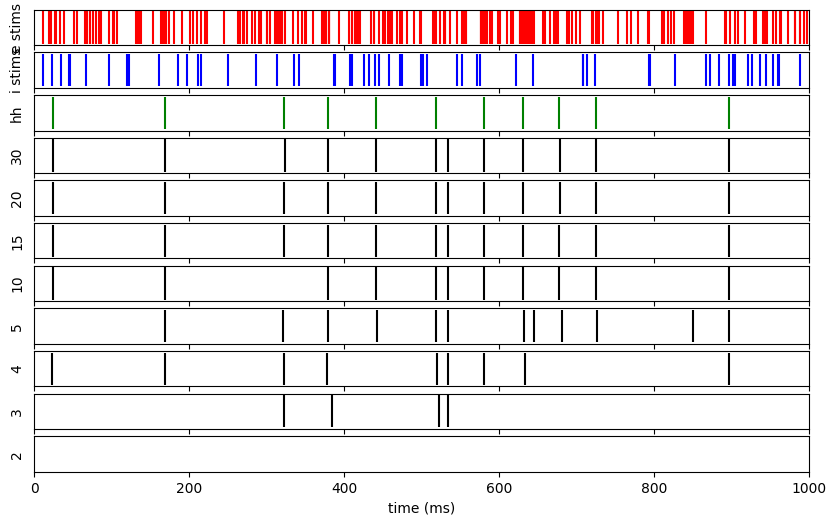

In [17]:
compare_rasters('lw', nInputs_results, gTruth_results)

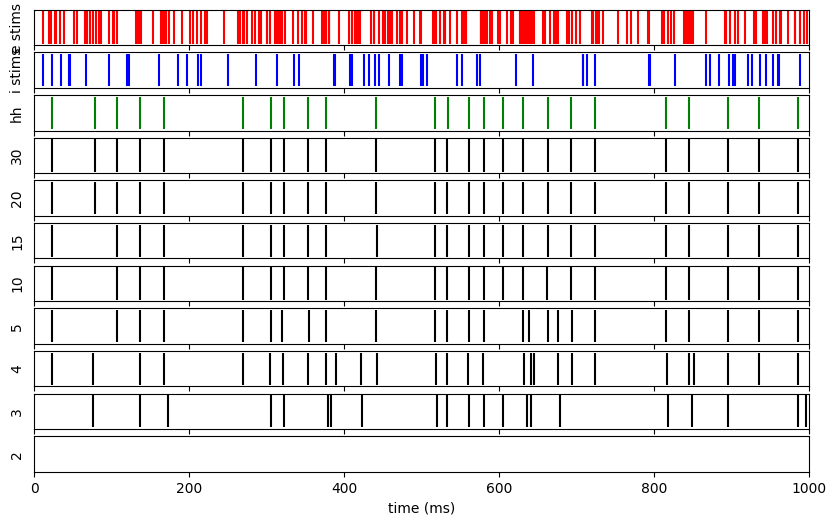

In [18]:
compare_rasters('base', nInputs_results, gTruth_results)

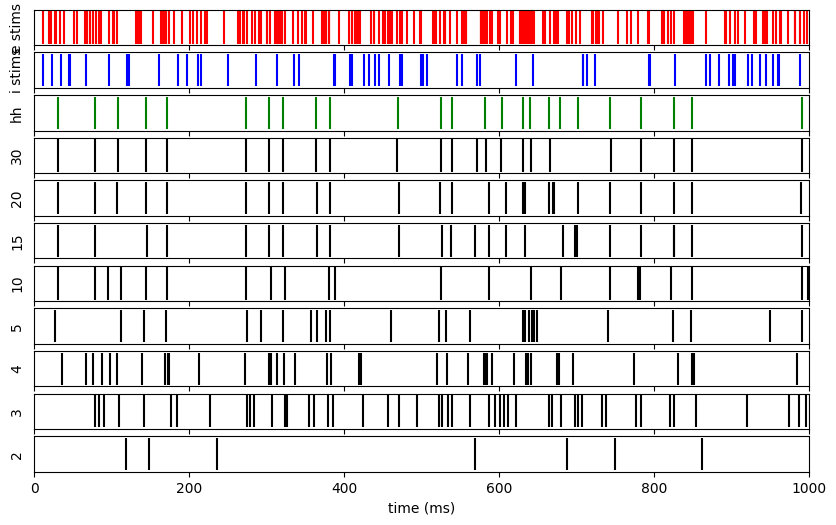

In [19]:
compare_rasters('wb', nInputs_wb_results, gTruth_wb_results)

## Compare ISIs

In [24]:
def compare_ISIs(model_type, results, gTruth_results, n_to_plot = [2,3,4,5,10,20], bins = np.arange(0,100,2), title=None):
    fig, ax = plt.subplots(figsize=(10,6))

    colors = ['gold','orange','darkorange','orangered','red','darkred','brown']
    alpha=0.6

    for i, n in enumerate(n_to_plot):
        train = results[model_type][n]
        ax.hist(([train[i] - train[i-1] for i in range(1,len(train))]), 
                 histtype='step', bins=bins,linewidth=3.0, alpha=alpha, color=colors[i])
        ax.hist(([train[i] - train[i-1] for i in range(1,len(train))]), 
                 bins=bins, alpha=0.1, color=colors[i])
    hh_spikes = gTruth_results[model_type]
    ax.hist(([hh_spikes[i] - hh_spikes[i-1] for i in range(1,len(hh_spikes))]), 
                 histtype='step', bins=bins,linewidth=3.0, alpha=alpha, color='black')

    ax.legend([f'{n} inputs' for n in n_to_plot] + ['hh spikes'], fontsize=14)
    ax.set_xlabel('time (ms)', fontsize=16)
    xticks = range(0,101,20)
    ax.set_xticks(xticks)
    ax.set_yticks([])
    ax.set_xticklabels(xticks, fontsize=16)
    ax.set_xlim(0,100)

    #ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if title:
        ax.set_title(title, fontsize=16)
    plt.show()

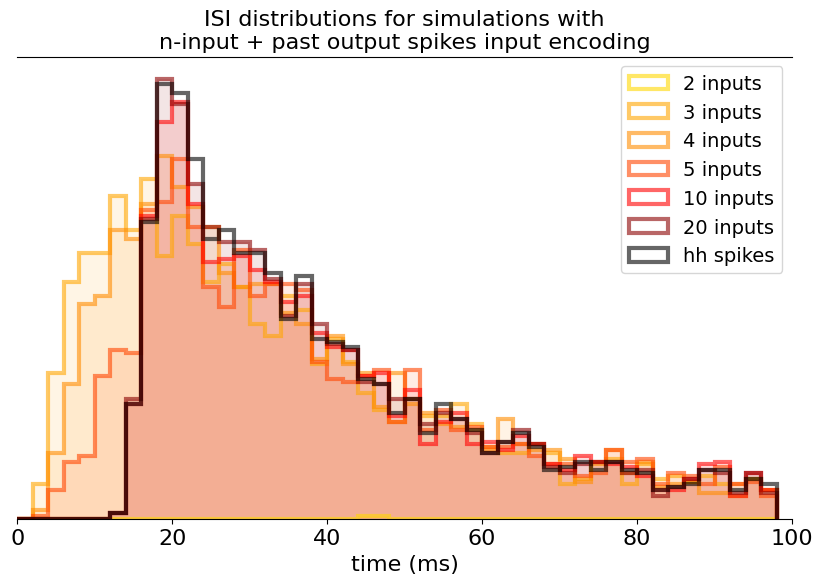

In [25]:
compare_ISIs(
    'base', nInputs_results, gTruth_results,
    title='ISI distributions for simulations with\nn-input + past output spikes input encoding')

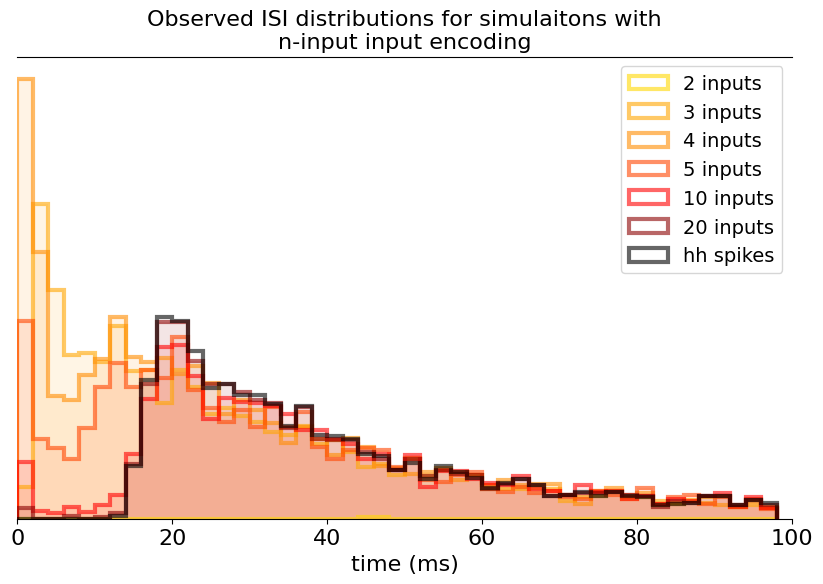

In [26]:
compare_ISIs(
    'base', 
    nInputs_nos_results,gTruth_results,
    title='Observed ISI distributions for simulaitons with\nn-input input encoding'
)

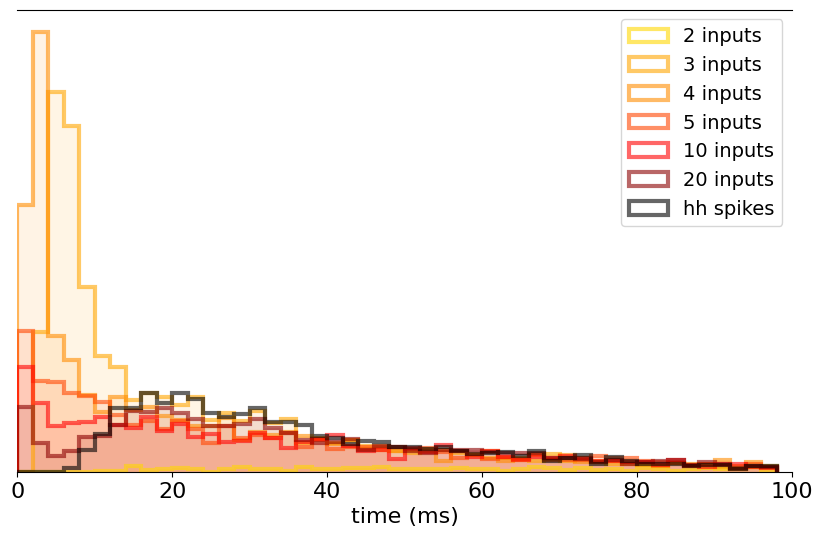

In [27]:
compare_ISIs(
    'wb', nInputs_wb_results, gTruth_wb_results,
    title='')

In [34]:
def compare_ISIs_KDE(model_type, results, gTruth_results, n_to_plot = [3,4,5,10,20], title=None):
    fig, ax = plt.subplots(figsize=(10,6))

    colors = ['gold','orange','darkorange','orangered','red','darkred','brown']
    alpha=0.6
    X_plot = np.linspace(0, 100, 1000)[:, np.newaxis]
    
    for i, n in enumerate(n_to_plot):
        train = results[model_type][n]
        isis = np.array([train[i] - train[i-1] for i in range(1,len(train))]).reshape(-1,1)
        kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(isis)
        log_dens = kde.score_samples(X_plot)

        ax.plot(X_plot, np.exp(log_dens), color=colors[i])
    
    
    hh_train = gTruth_results[model_type]
    hh_isis = np.array([hh_train[i] - hh_train[i-1] for i in range(1,len(hh_train))]).reshape(-1,1)
    hh_kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(hh_isis)
    hh_log_dens = hh_kde.score_samples(X_plot)
    ax.plot(X_plot, np.exp(hh_log_dens), color='black', linestyle='dashed')

    ax.legend([f'{n} inputs' for n in n_to_plot] + ['full history'], fontsize=14)
    ax.set_xlabel('time (ms)', fontsize=16)
    xticks = range(0,101,20)
    ax.set_xticks(xticks)
    ax.set_yticks([])
    ax.set_xticklabels(xticks, fontsize=16)
    ax.set_xlim(0,100)

    #ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if title:
        ax.set_title(title, fontsize=16)
    plt.show()

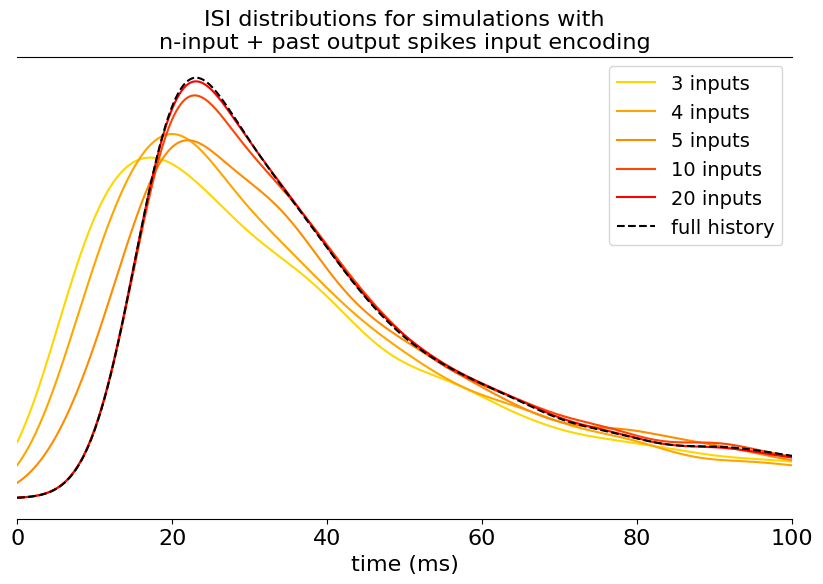

In [35]:
compare_ISIs_KDE(
    'base', nInputs_results, gTruth_results, n_to_plot = [3,4,5,10,20],
    title='ISI distributions for simulations with\nn-input + past output spikes input encoding')

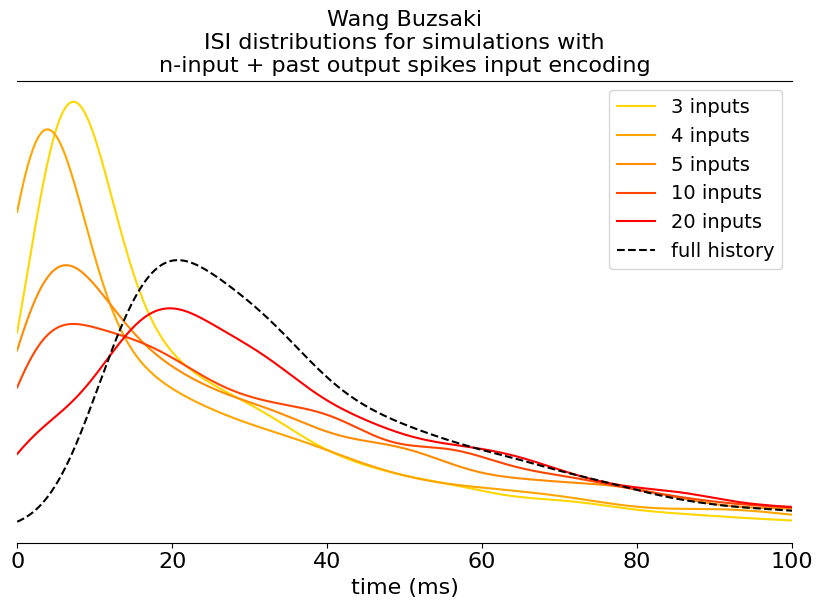

In [42]:
compare_ISIs_KDE(
    'wb', nInputs_wb_results, gTruth_wb_results, n_to_plot = [3,4,5,10,20],
    title='Wang Buzsaki\nISI distributions for simulations with\nn-input + past output spikes input encoding')

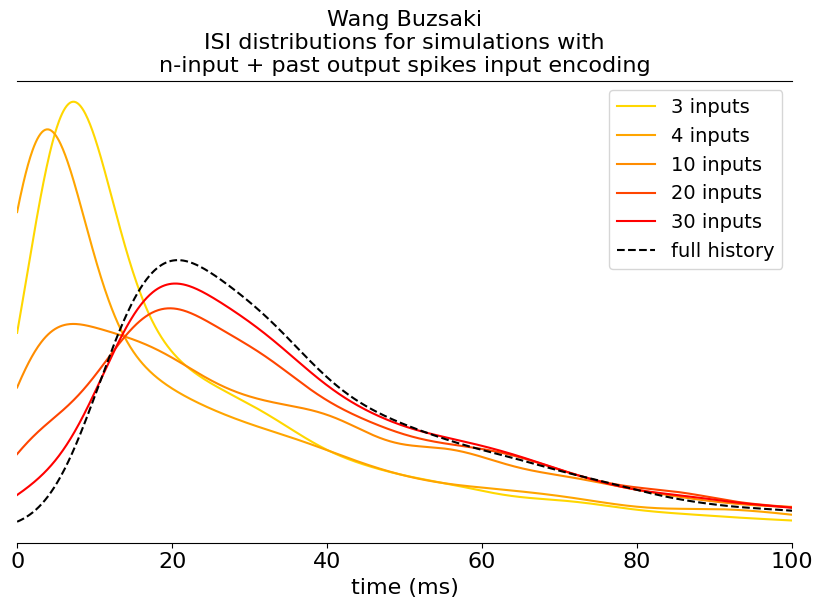

In [43]:
compare_ISIs_KDE(
    'wb', nInputs_wb_results, gTruth_wb_results, n_to_plot = [3,4,10,20,30],
    title='Wang Buzsaki\nISI distributions for simulations with\nn-input + past output spikes input encoding')

In [32]:
model_types = ['base', 'lw', 'lt',  'lwlt', 'burst']
modeltype2color = {
    'base':'maroon',
    'lw':'orangered',
    'lt':'darkgreen',
    'lwlt':'teal',
    'burst':'indigo'
}

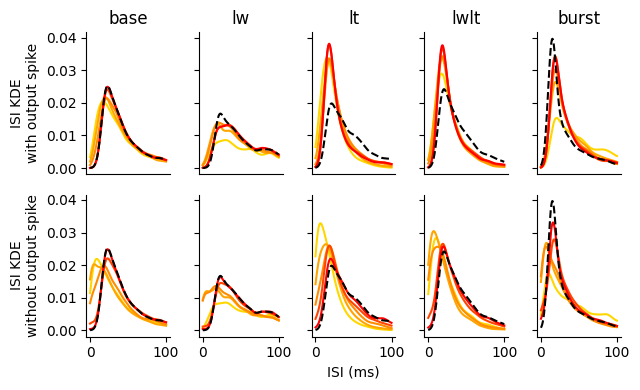

In [33]:
x_max = 100

# models to plot specifics
n_to_plot = [3,4,5,10,20]

# KDE specifics
X_plot = np.linspace(0, x_max, 1000)[:, np.newaxis]

# figure specifics
fig, axes = plt.subplots(2,5, figsize=(6.5,4), sharey=True)

colors = ['gold','orange','darkorange','orangered','red','darkred','brown']

for ax_x, model_type in enumerate(model_types):
    
    for i, n in enumerate(n_to_plot):
        # with output spike
        train = nInputs_results[model_type][n]
        isis = np.array([train[i] - train[i-1] for i in range(1,len(train))]).reshape(-1,1)
        kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(isis)
        log_dens = kde.score_samples(X_plot)
        axes[0, ax_x].plot(X_plot, np.exp(log_dens), color=colors[i])
        
        # without output spike
        train = nInputs_nos_results[model_type][n]
        isis = np.array([train[i] - train[i-1] for i in range(1,len(train))]).reshape(-1,1)
        kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(isis)
        log_dens = kde.score_samples(X_plot)
        axes[1, ax_x].plot(X_plot, np.exp(log_dens), color=colors[i])

    # ground truth
    hh_train = gTruth_results[model_type]
    hh_isis = np.array([hh_train[i] - hh_train[i-1] for i in range(1,len(hh_train))]).reshape(-1,1)
    hh_kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(hh_isis)
    hh_log_dens = hh_kde.score_samples(X_plot)
    axes[0, ax_x].plot(X_plot, np.exp(hh_log_dens), color='black', linestyle='dashed')
    axes[1, ax_x].plot(X_plot, np.exp(hh_log_dens), color='black', linestyle='dashed')
    
    # plot aesthetics
    axes[0, ax_x].spines['right'].set_visible(False)
    axes[0, ax_x].spines['top'].set_visible(False)
    axes[1, ax_x].spines['right'].set_visible(False)
    axes[1, ax_x].spines['top'].set_visible(False)
    
    axes[0, ax_x].set_xticks([])
    axes[0, ax_x].set_title(model_type)
    
axes[0,0].set_ylabel('ISI KDE\nwith output spike')
axes[1,0].set_ylabel('ISI KDE\nwithout output spike')
axes[1,2].set_xlabel('ISI (ms)')

plt.tight_layout()

savefig = False
if savefig: 
    plt.savefig(f'{figures_dir}nInputs_point_cell_ISI_dists.svg', format='svg')
    plt.savefig(f'{figures_dir}nInputs_point_cell_ISI_dists.png', format='png', dpi=300)

plt.show()

In [ ]:
savefig = False

figures_dir = '../figures/'
fig = plt.figure(figsize = (6.5,1))
ax = fig.add_subplot(111, )

n_to_plot = [3,4,5,10,20]
colors = ['gold','orange','darkorange','orangered','red','darkred','brown']
# figure specifics

for i, n in enumerate(n_to_plot):
    ax.plot([0,0],[1,1], color=colors[i])

ax.plot([0,0],[1,1], color='black', linestyle='dashed')

plt.legend(['3 inputs','4 inputs','5 inputs','10 inputs','20 inputs','full history'], ncol=3)
    
if savefig:
    plt.savefig(f'{figures_dir}nInputs_point_cell_ISI_legend.svg', format='svg')
else:
    plt.show()

## Spike train comparison metrics

In [ ]:
q = 1.0 / (10.0 * ms) # cost factor for shifting spikes in the victor purpura distance
tau = 10.0 * ms # time constant for the van rossum distance

In [ ]:
sim_duration = 100000

In [ ]:
nInputs_trains = {
    'base':{},
    'lw':{},
    'lt':{},
    'lwlt':{},
    'burst':{},
}

nInputs_nos_trains = {
    'base':{},
    'lw':{},
    'lt':{},
    'lwlt':{},
    'burst':{},
}

In [ ]:
gTruth_trains = {
    'base':None,
    'lw':None,
    'lt':None,
    'lwlt':None,
    'burst':None,
}

In [ ]:
for model_type in nInputs_results:
    gTruth_trains[model_type] = neo.SpikeTrain(gTruth_results[model_type] * ms, t_stop=sim_duration*ms)
    for n in range(2,31):
        nInputs_trains[model_type][n] = neo.SpikeTrain(nInputs_results[model_type][n] * ms, t_stop=sim_duration*ms)
        nInputs_nos_trains[model_type][n] = neo.SpikeTrain(nInputs_nos_results[model_type][n] * ms, t_stop=sim_duration*ms)

In [ ]:
vp_dists = {
    'base':{},
    'lw':{},
    'lt':{},
    'lwlt':{},
    'burst':{},
}
vr_dists = {
    'base':{},
    'lw':{},
    'lt':{},
    'lwlt':{},
    'burst':{},
}

vp_dists_nos = {
    'base':{},
    'lw':{},
    'lt':{},
    'lwlt':{},
    'burst':{},
}
vr_dists_nos = {
    'base':{},
    'lw':{},
    'lt':{},
    'lwlt':{},
    'burst':{},
}

for model_type in nInputs_results:
    for n in range(2,31):
        vp_dists[model_type][n] = victor_purpura_distance(
            [gTruth_trains[model_type], nInputs_trains[model_type][n]], q)[0, 1]
        vr_dists[model_type][n] = van_rossum_distance(
            [gTruth_trains[model_type], nInputs_trains[model_type][n]], tau)[0, 1]
        vp_dists_nos[model_type][n] = victor_purpura_distance(
            [gTruth_trains[model_type], nInputs_nos_trains[model_type][n]], q)[0, 1]
        vr_dists_nos[model_type][n] = van_rossum_distance(
            [gTruth_trains[model_type], nInputs_nos_trains[model_type][n]], tau)[0, 1]

In [ ]:
model_types = ['base', 'lw', 'lt',  'lwlt', 'burst']
modeltype2color = {
    'base':'maroon',
    'lw':'orangered',
    'lt':'darkgreen',
    'lwlt':'teal',
    'burst':'indigo'
}

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,7))
legend_labels = []
for i, model_type in enumerate(model_types):
    ax.plot(range(2,31), vp_dists[model_type].values(), c=modeltype2color[model_type], linewidth=3, alpha=0.8)
    ax.plot(range(2,31), vp_dists_nos[model_type].values(), '--', 
             c=modeltype2color[model_type], linewidth=3, alpha=0.8)
    legend_labels.append(model_type + ' n-inputs + spike')
    legend_labels.append(model_type + ' n-inputs')
    
ax.set_xlim(2, 30)  
ax.set_ylabel('Victor Purpura distance', fontsize=16)
ax.set_xlabel('n inputs', fontsize=16)

ax.set_xticks(np.arange(5,31,5))
ax.set_xticklabels(np.arange(5,31,5), fontsize=14)

ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(legend_labels, fontsize=12)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,7))
legend_labels = []
for i, model_type in enumerate(model_types):
    ax.plot(range(2,31), vr_dists[model_type].values(), c=modeltype2color[model_type], linewidth=3, alpha=0.8)
    ax.plot(range(2,31), vr_dists_nos[model_type].values(), '--', 
             c=modeltype2color[model_type], linewidth=3, alpha=0.8)
    legend_labels.append(model_type + ' n-inputs + spike')
    legend_labels.append(model_type + ' n-inputs')
    
ax.set_xlim(2, 30)  
plt.ylabel('van Rossum distance', fontsize=16)
ax.set_xlabel('n inputs', fontsize=16)

ax.set_xticks(np.arange(5,31,5))
ax.set_xticklabels(np.arange(5,31,5), fontsize=14)

ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(legend_labels, fontsize=12)
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(3.25,6), sharex=True)
legend_labels = []
for i, model_type in enumerate(model_types):
    for j in range(5):
        if j != i:
            axes[j].plot(
                range(2,31), vr_dists[model_type].values(), 
                c='grey', linewidth=1, alpha=0.8
            )
            axes[j].plot(
                range(2,31), vr_dists_nos[model_type].values(), '--', 
                c='grey', linewidth=1, alpha=0.8
            )
    
    axes[i].plot(
        range(2,31), vr_dists[model_type].values(), 
        c=modeltype2color[model_type], linewidth=2, alpha=1, zorder=100
    )
    axes[i].plot(
        range(2,31), vr_dists_nos[model_type].values(), '--', 
        c=modeltype2color[model_type], linewidth=2, alpha=1, zorder=100
    )
    axes[i].set_ylabel(model_type)
    
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    legend_labels.append(model_type + ' n-inputs + spike')
    legend_labels.append(model_type + ' n-inputs')
    
axes[0].set_xlim(3, 30)  
axes[-1].set_xlabel('n inputs')

axes[0].set_xticks(np.arange(5,31,5))
axes[0].set_xticklabels(np.arange(5,31,5))

ax.legend(legend_labels)

savefig=False
if savefig:
    plt.savefig(f'{figures_dir}nInputs_point_cell_vr_dists.svg', format='svg')
    plt.savefig(f'{figures_dir}nInputs_point_cell_vr_dists.png', format='png', dpi=300)

plt.show()

In [ ]:
plt.figure(figsize=(3.25,2))
plt.plot([0,0], [1,1], color='black', linewidth=2)
plt.plot([0,0], [1,1], '--', color='black', linewidth=2)

plt.legend(['input encoding with last\noutput spike', 'input encoding without last\noutput spike'])

savefig=False
if savefig:
    plt.savefig(f'{figures_dir}nInputs_point_cell_vr_dists_legend.svg', format='svg')
else:
    plt.show()